In [1]:
%load_ext autoreload
%autoreload 2

# Preparation to experiment

## Imports and help functions for demonstration

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
from dataclasses import dataclass
from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# inverse wishart class
from bmm_multitask_learning.coalescent.inverse_wishart import InverseWishart

# обертка над данными одной задачи
from bmm_multitask_learning.coalescent.task_classes import TaskData

# солвер для задачи
from bmm_multitask_learning.coalescent.coalescent_learner import MultitaskProblem

# обертка для линейной модели
from bmm_multitask_learning.coalescent.utils import MyModel


def print_table(r2, mse, K):
    print(tabulate([["R2", *r2], ["MSE", *mse]], headers=["Metric", *[f"Value_{i}" for i in range(K)]], tablefmt="grid"))

def test_models(X, Y, models, K):
    r2 = []
    mse = []
    for i in range(Y.shape[1]):
        task_prediction = models[i].predict(X)
        true_labels = Y[:, i]
        r2.append(r2_score(true_labels, task_prediction))
        mse.append(mean_squared_error(true_labels, task_prediction))
    return np.array(r2), np.array(mse)

## data generator via Coalescent process

In [3]:
@dataclass
class Node:
    mean: float
    cov: float
    t: float
    parent: int
    children: list[int]

def generate_coalescent(K):
    nodes = set(range(K))
    tree_nodes = {i: {"parent":None, "children": [], "delta": -float("inf")} for i in range(K)}
    new_node = -1
    while len(nodes) > 1:
        l, r = np.random.choice(list(nodes), 2, replace=False,)
        nodes.remove(l)
        nodes.remove(r)
        
        new_node = max(tree_nodes.keys()) + 1
        
        nodes.add(new_node)
        tree_nodes[new_node] = {"parent": None, "children": [l,r], "delta": -float("inf")}
        
        tree_nodes[l]["parent"] = new_node
        tree_nodes[r]["parent"] = new_node
        tree_nodes[l]["delta"] = np.random.exponential(1)
        tree_nodes[r]["delta"] = np.random.exponential(1)
    
    tree_nodes['root'] = tree_nodes[new_node]
    return tree_nodes

def get_weights(tree, d, sigma, R):
    weights = []
    s_gt = []
    def generate_w(node, tree, d, sigma,):
        if node["parent"] is None:
            node["w"] = np.random.randn(d)
        else:
            node["w"] = np.random.normal(tree[node["parent"]]["w"], sigma * (node["delta"]))
            
        for child in node["children"]:
            generate_w(tree[child], tree, d, sigma)
        if len(node["children"]) == 0:
            s = node["w"]
            s_exp = np.diag(np.exp(s))
            Sigma = s_exp @ R @ s_exp
            w = np.random.multivariate_normal(np.zeros(d), Sigma)
            s_gt.append(s)
            weights.append(w)

    generate_w(tree['root'], tree, d, sigma)
    return np.stack(weights), np.stack(s_gt)

# Experiment setting

## Задаем параметры задачи и генерируем данные

In [4]:
# define parameters

K = 20  # number of tasks
n = 40  # number of data points per task
task_dimention = 10  #dimention of task
sigma = 0.1  # divergence rate of tasks

# задаем общую ковариационную матрицу для задач
R_gt = stats.invwishart.rvs(df=task_dimention, scale=np.eye(task_dimention), size=1)
R_gt = InverseWishart.cov2corr(R_gt)

# R_gt = np.eye(d)  # другой пример

# генерируем ковариации для весов и сами веса
tree = generate_coalescent(K)
weights_gt, s_gt = get_weights(tree, task_dimention, sigma, R_gt)

# генерируем данные. Скейлер для шума в целях демонстрации подбираем адаптивно
# необходимо, чтобы ground truth веса хорошо справлялись, а обучаемые -- плохо

noise_scale = weights_gt.max(axis = 1)[None, :] * 1.5

# генерируем данные для обучения
X = np.random.randn(n, task_dimention)
Y = np.dot(X, weights_gt.T) + np.random.randn(n, K) * noise_scale

# генерируем данные для теста
X_test = np.random.randn(n, task_dimention)
Y_test = np.dot(X_test, weights_gt.T) + np.random.randn(n, K) * noise_scale

print(Y.shape)

(40, 20)


## Смотрим на работу исходных весов и обученной линейной регрессии

видно, что линейная регрессия плохо справляется

In [5]:
print("Ground truth")
models_gt = [MyModel(weights_gt[i]) for i in range(K)]
print_table(*test_models(X_test, Y_test, models_gt,K), K)

print("LinearRegression")
models = []
for i in range(Y.shape[1]):
    model = LinearRegression()
    model.fit(X, Y[:, i])
    models.append(model)
print_table(*test_models(X_test, Y_test, models, K), K )

Ground truth
+----------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
| Metric   |    Value_0 |   Value_1 |   Value_2 |   Value_3 |   Value_4 |   Value_5 |   Value_6 |   Value_7 |   Value_8 |   Value_9 |   Value_10 |   Value_11 |   Value_12 |   Value_13 |   Value_14 |   Value_15 |   Value_16 |   Value_17 |   Value_18 |   Value_19 |
+==========+============+===========+===========+===========+===========+===========+===========+===========+===========+===========+============+============+============+============+============+============+============+============+============+============+
| R2       |   0.260993 |  0.782468 |  0.356231 |  0.678716 |  0.436923 |  0.486206 |  0.487526 |  0.595509 |  0.690502 |  0.552038 |   0.541004 |   0.402476 |   0.398552 |   0.518333 |   0.55074

## обучение предложенной модели

для этого готовим данные в TaskData для разных тасок.

параметр `selection_count` задает количество данных, которое будет использоваться при обучении

In [6]:
def select_for_task(X, y, task_pos, selection_count):
    selected = np.random.choice(X.shape[0], selection_count, replace=False)
    X_task = X[selected]
    y_task = y[selected][:, task_pos][:, None]
    return X_task, y_task

tasks = []
selection_count = n

for i in range(K):
    X_task, y_task = select_for_task(X, Y, i, selection_count)
    X_task = X_task
    task = TaskData(X_task, y_task)
    tasks.append(task)


### обучение

задаем параметры обучения и запускаем обучение

`rho` -- насколько смотреть на prior важнее чем на данные. Данные учитываются с весом 1/rho. 

`cov_sigma` -- скейл матрицы ковариации

In [7]:
rho = 0.05
cov_sigma=0.1
optimization_steps = 200

problem = MultitaskProblem(tasks, 
                           dim=task_dimention, 
                           rho=rho,
                           cov_sigma=cov_sigma,
    )

problem.fit(n_steps=optimization_steps)
weights_coalescent = problem.weights

# результаты обучения

сравним результаты обучения трех моделей:

* `GroundTruth` -- ground truth веса
* `Coalescent` -- Coalescent learinig
* `Linear regression` -- линейная регрессия для моделей отдельно

In [8]:
# now we compute r2 and mean squared error

print("Ground truth")
models_gt = [MyModel(weights_gt[i]) for i in range(K)]
gt_res = test_models(X_test, Y_test, models_gt,K)

print("Coalescent")
models_mp = [MyModel(weights_coalescent[i]) for i in range(K)]
mp_res = test_models(X_test, Y_test, models_mp, K)

print("LinearRegression")
models = []
for i in range(Y.shape[1]):
    model = LinearRegression()
    model.fit(X, Y[:, i])
    models.append(model)
weight_lr = [m.coef_ for m in models]
lr_res = test_models(X_test, Y_test, models, K)

Ground truth
Coalescent
LinearRegression


### представление результатов
отсортируем результаты по задачам согласно R2 простых линейных моделей.

Тогда увидим, что `Coalescent` с ними в основном справляется лучше.

Но при этом с простыми задачами -- на которые линейная регрессия хорошо настраивается -- `Coalescent` часто справляется хуже

In [9]:
ind = np.argsort(lr_res[0])

print("Ground truth")
print_table(gt_res[0][ind], gt_res[1][ind], K)

print("Coalescent")
print_table(mp_res[0][ind], mp_res[1][ind], K)
print("LinearRegression")
print_table(lr_res[0][ind], lr_res[1][ind], K)

Ground truth
+----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
| Metric   |   Value_0 |   Value_1 |   Value_2 |    Value_3 |   Value_4 |   Value_5 |   Value_6 |   Value_7 |    Value_8 |   Value_9 |   Value_10 |   Value_11 |   Value_12 |   Value_13 |   Value_14 |   Value_15 |   Value_16 |   Value_17 |   Value_18 |   Value_19 |
+==========+===========+===========+===========+============+===========+===========+===========+===========+============+===========+============+============+============+============+============+============+============+============+============+============+
| R2       |  0.436923 |   0.18931 |  0.429566 |   0.260993 |  0.541004 |  0.388669 |  0.398552 |  0.356231 |   0.402476 |  0.486206 |   0.548935 |   0.550749 |   0.552038 |   0.487526 |   0.5

представим эти таблицы на графиках. 
По оси x также задачи отсортированы по R2 простых линейных моделей

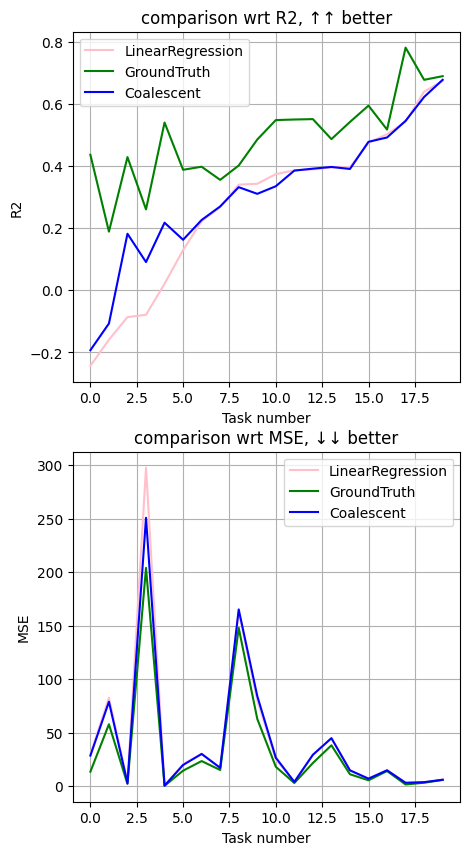

In [10]:
fig, axs = plt.subplots(2,1, figsize = (5, 10))

ind = np.argsort(lr_res[0])
for ax, res_index, loss_name in zip(axs, [0,1], ["R2, ↑↑", "MSE, ↓↓"]):
    denum = mp_res[res_index][ind]
    for num, alg_name, color in zip(
            [lr_res[res_index], gt_res[res_index], mp_res[res_index]], 
            ["LinearRegression", "GroundTruth", "Coalescent"],
            ["pink", "green", "blue"]
            ):
        num = num[ind]
        ax.plot(num, label = alg_name, color = color)

    ax.set_xlabel("Task number")
    ax.set_ylabel(f"{loss_name[:-4]}")
    ax.set_title(f"comparison wrt {loss_name} better")
    ax.legend()
    ax.grid()

и на последнем наборе графиков предствим отношение графиков нарисованных выше для MSE лосса

чем меньше тем лучше

видим, что на сложных для linear regression задач Coalescent справляется лучше. 

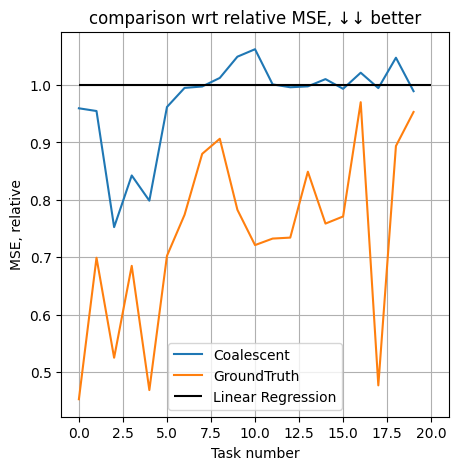

In [11]:


fig, ax = plt.subplots(1,1, figsize = (5, 5))
res_index, loss_name = 1,  "MSE, ↓↓"
denum = lr_res[res_index][ind]
for num, alg_name in zip([mp_res[res_index], gt_res[res_index]], ["Coalescent", "GroundTruth"]):
    num = num[ind]
    ax.plot((num)/denum, label = alg_name)

ax.hlines(1, 0, K, colors=["black"], label="Linear Regression")
ax.set_xlabel("Task number")
ax.set_ylabel(f"{loss_name[:-4]}, relative")
ax.set_title(f"comparison wrt relative {loss_name} better")
ax.legend()
ax.grid()


uhf

### validate that R updates truly

In [12]:
assert task_dimention == 2, "this demonstration works only for d = 2"

s = np.array([0.1, -0.2])
s_exp = np.diag(np.exp(s))
cov = s_exp @ R_gt @ s_exp

n_iters = 100
n_samples = 1000
R_distr = InverseWishart(2, 2+1, corr_mat=True)

for i in range(n_iters):
    cov = s_exp @ R_gt @ s_exp
    samples = np.random.multivariate_normal([0, 0], cov, n_samples)
    s_leaves = np.repeat(s[None,:], n_samples, axis=0)

    r_samples = optimal_R(s_leaves, samples)

    R_distr.update_posterior(r_samples)

print(R_gt)
print(R_distr.get_most_prob())
# w = 


AssertionError: this demonstration works only for d = 2